In [1]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo
!pip install open3d

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-olsngmtq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-olsngmtq
  Resolved https://github.com/facebookresearch/fvcore.git to commit 3b2d62f06b22ef743ac394e568e1e87ae12b30a8
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-46l1kw__
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-46l1kw__
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65635 sha256=f7d23f6caa82f246df059e59f3850d54b3bcbda83b417f45c68264718690401e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0zoj9xof/wheels/cb/7b/f1/170e6ac46b414a6afef30f04f353ef29c6d7b20051358b781a


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import open3d as o3d
import os
from google.colab import drive
import torch, torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import random
from google.colab.patches import cv2_imshow

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/ThinkAuto/vision1")

Mounted at /content/drive


In [4]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

In [5]:
def display_image(index, image_files, point_files):
  """
  Display the image given the index

  Args:
    index: index of the image
    image_files: list of image files
    point_files: list of point files

  Returns:
    image: image
    points: point cloud
  """

  pcd_file = point_files[index]
  image = cv2.imread(image_files[index])
  cloud = o3d.io.read_point_cloud(pcd_file)
  points = np.asarray(cloud.points)
  cv2_imshow(image)

  return image, points

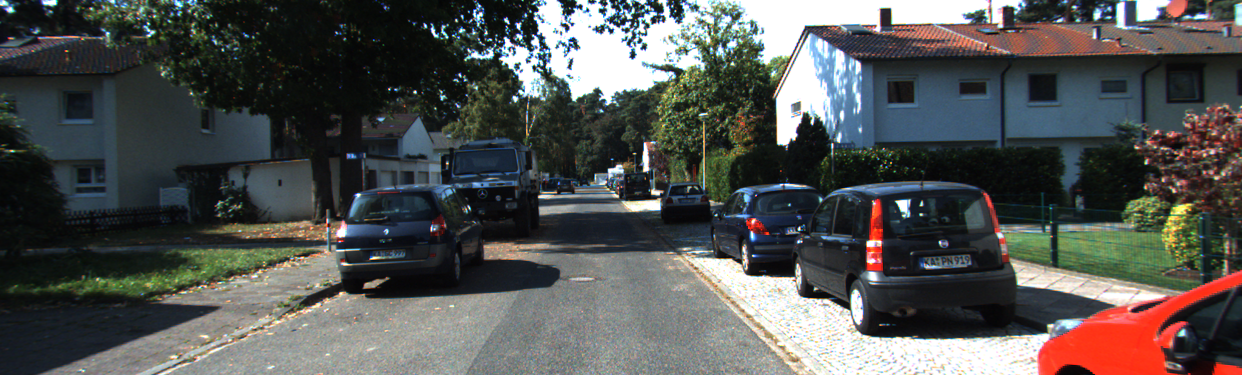

In [6]:
# for debugging
index = 0
image, points = display_image(index, image_files, point_files)

In [7]:
class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        P = calibs["P2"]
        self.P = np.reshape(P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        RT = calibs["Tr_velo_to_cam"]
        self.RT = np.reshape(RT, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        R0 = calibs["R0_rect"]
        self.R0 = np.reshape(R0, [3, 3])

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

In [8]:
# for debugging
lidar2cam = LiDAR2Camera(calib_files[index])
print(f"P [{lidar2cam.P.shape}] ->\n {lidar2cam.P}")
print(f"R0 [{lidar2cam.R0.shape}] ->\n {lidar2cam.R0}")
print(f"R|t [{lidar2cam.RT.shape}] ->\n {lidar2cam.RT}")

P [(3, 4)] ->
 [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
R0 [(3, 3)] ->
 [[ 0.9999239   0.00983776 -0.00744505]
 [-0.0098698   0.9999421  -0.00427846]
 [ 0.00740253  0.00435161  0.9999631 ]]
R|t [(3, 4)] ->
 [[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


In [9]:
def project_lidar_to_image(self, pts_3d_lidar):
    """
    Project 3D LiDAR points to 2D image plane using perspective projection [P x R0 x RT x X]

    Args:
        pts_3d_lidar: (N, 3)
    Returns:
        pts_2d: (N, 2)
    """
    # R0 : (3, 3) -> (4, 4)
    R0_final = np.eye(4)
    R0_final[:3, :3] = self.R0

    # P x R0 : (3, 4) x (4, 4) -> (3, 4)
    p_r0 = np.dot(self.P, R0_final)

    # RT : (3, 4) -> (4, 4)
    # P x R0 x RT : (3, 4) x (4, 4) -> (3, 4)
    p_r0_rt =  np.dot(p_r0, np.vstack((self.RT, [0, 0, 0, 1])))

    # X : (1, 3) -> (1, 4)
    pts_3d_homo = np.column_stack([pts_3d_lidar, np.ones((pts_3d_lidar.shape[0],1))])

    # [P x R0 x RT] x X : (3, 4) x (4, 1) -> (3, 1)
    p_r0_rt_x = np.dot(p_r0_rt, np.transpose(pts_3d_homo))
    pts_2d = np.transpose(p_r0_rt_x)

    # To Pixel Coordinates, dividing by last coordinate
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]

    return pts_2d[:, 0:2]

In [10]:
# for debugging
LiDAR2Camera.project_lidar_to_image = project_lidar_to_image
print(points[:5,:3])
print(f"In pixels {lidar2cam.project_lidar_to_image(points[:5,:3])}")

[[21.75099945  2.53399992  0.94999999]
 [21.76199913  2.60500002  0.94999999]
 [21.76600075  2.67499995  0.95099998]
 [21.73800087  2.70600009  0.94999999]
 [21.76099968  2.77800012  0.95099998]]
In pixels [[526.23638509 146.95787607]
 [523.89669251 147.00016352]
 [521.56394771 146.99766647]
 [520.40796015 146.99871677]
 [518.08712666 147.02643408]]


In [11]:
def get_lidar_in_image_fov(self, pc_lidar, xmin, ymin, xmax, ymax, clip_distance=2.0):
    """
    Filter LiDAR points, keep those in image FOV

    Args:
        pc_lidar: (N, 3)
        xmin: Image x coordinate min
        xmax: Image x coordinate max
        ymin: Image y coordinate min
        ymax: Image y coordinate max
    Returns:
        imgfov_pc_lidar: (M, 3), where points are in image FOV
        pts_2d: (M, 2), pixel coordinates of LiDAR points in image FOV
        fov_inds: (M), indices of LiDAR points in image FOV
    """
    pts_2d = self.project_lidar_to_image(pc_lidar)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )

    # We don't want points that are closer to the clip distance (2m)
    fov_inds = fov_inds & (pc_lidar[:, 0] > clip_distance)
    imgfov_pc_lidar = pc_lidar[fov_inds, :]

    return imgfov_pc_lidar, pts_2d, fov_inds

In [12]:
# for debugging
LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov
imgfov_pc_lidar, pts_2d, fov_inds = lidar2cam.get_lidar_in_image_fov(points[:,:3], 0, 0, image.shape[1], image.shape[0])
print(f"3D LiDAR Points: {imgfov_pc_lidar}, \n2D Pixel: {pts_2d}, \nFOV: {fov_inds}")

3D LiDAR Points: [[ 2.17509995e+01  2.53399992e+00  9.49999988e-01]
 [ 2.17619991e+01  2.60500002e+00  9.49999988e-01]
 [ 2.17660007e+01  2.67499995e+00  9.50999975e-01]
 ...
 [ 6.55200005e+00 -5.40000014e-02 -1.71500003e+00]
 [ 6.55000019e+00 -3.29999998e-02 -1.71500003e+00]
 [ 6.54799986e+00 -1.30000003e-02 -1.71399999e+00]], 
2D Pixel: [[526.23638509 146.95787607]
 [523.89669251 147.00016352]
 [521.56394771 146.99766647]
 ...
 [867.30336642 527.81853192]
 [864.67189344 527.48206865]
 [862.01722625 527.14567793]], 
FOV: [ True  True  True ... False False False]


In [13]:
def show_lidar_on_image(self, pc_lidar, img, debug=False):
    """
    Project LiDAR points to image

    Args:
      pc_lidar: (N, 3), LiDAR points
      img: (H, W, 3), test image
      debug: bool, whether to print debugging info

    Returns:
      img: (H, W, 3) with LiDAR points projected
    """
    imgfov_pc_lidar, pts_2d, fov_inds = self.get_lidar_in_image_fov(pc_lidar, 0, 0, img.shape[1], img.shape[0])

    if debug:
         print(f"3D LiDAR Points: {imgfov_pc_lidar}, \n2D Pixel: {pts_2d}, \nFOV: {fov_inds}")

    self.imgfov_pts_2d = pts_2d[fov_inds, :]

    cmap = plt.get_cmap("turbo", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_lidar = imgfov_pc_lidar
    test_image = img.copy()
    for i in range(self.imgfov_pts_2d.shape[0]):
        depth = imgfov_pc_lidar[i,0]
        color = cmap[int(510.0 / depth), :]
        cv2.circle(
            test_image,
            center=(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),
            radius=2,
            color=tuple(color),
            thickness=-1,
        )

    return test_image

3D LiDAR Points: [[ 2.17509995e+01  2.53399992e+00  9.49999988e-01]
 [ 2.17619991e+01  2.60500002e+00  9.49999988e-01]
 [ 2.17660007e+01  2.67499995e+00  9.50999975e-01]
 ...
 [ 6.55200005e+00 -5.40000014e-02 -1.71500003e+00]
 [ 6.55000019e+00 -3.29999998e-02 -1.71500003e+00]
 [ 6.54799986e+00 -1.30000003e-02 -1.71399999e+00]], 
2D Pixel: [[526.23638509 146.95787607]
 [523.89669251 147.00016352]
 [521.56394771 146.99766647]
 ...
 [867.30336642 527.81853192]
 [864.67189344 527.48206865]
 [862.01722625 527.14567793]], 
FOV: [ True  True  True ... False False False]


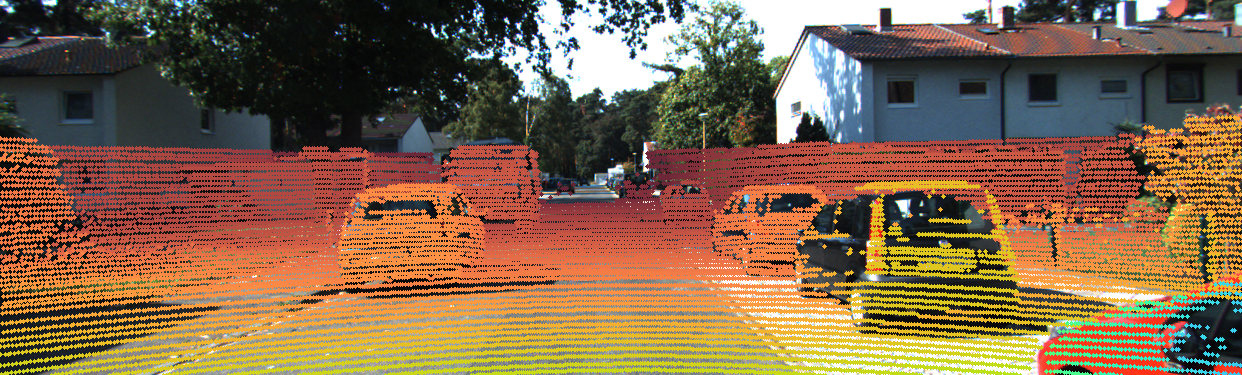

In [14]:
# for debugging
LiDAR2Camera.show_lidar_on_image = show_lidar_on_image
test_image = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], test_image, True)
cv2_imshow(img_3)

In [15]:
def get_segmentation(self, img):
  """
  Get Instance Segmentation masks for the given image

  Args:
    img: (H, W, 3), image

  Returns:
    cfg: detectron2 config
    outputs: dict, output of the model
  """
  cfg = get_cfg()
  cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
  # Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
  cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
  predictor = DefaultPredictor(cfg)
  outputs = predictor(img)

  self.outputs = outputs

  return cfg, outputs

[08/04 18:00:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 262MB/s]                           
/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


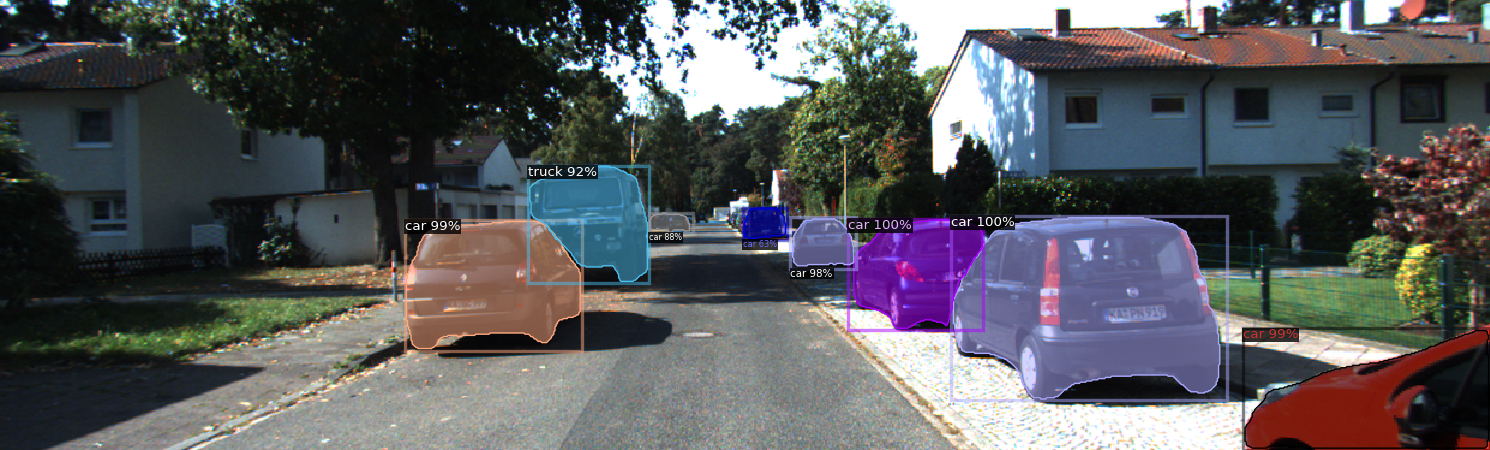

In [16]:
# We can use `Visualizer` to draw the predictions on the image.
LiDAR2Camera.get_segmentation = get_segmentation

test_image = image.copy()
cfg, outputs = lidar2cam.get_segmentation(test_image)
viz = Visualizer(test_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
viz = viz.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(viz.get_image()[:, :, ::-1])

In [17]:
# setup
classes = outputs["instances"].pred_classes.cpu().numpy()
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes")
boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
masks = outputs["instances"].pred_masks.cpu()

In [18]:
def get_matched_points(self, masks):
  """
  Get matched points (LiDAR, image) within the masks

  Args:
    masks: (N, H, W), detectron masks

  Returns:
    object_all_points: dict, LiDAR and image points within the filtered masks
  """
  object_all_points = {}

  for i, mask in enumerate(masks):
    matched_points = []
    mask_h, mask_w = mask.shape
    for (u, v), pt in zip(self.imgfov_pts_2d, self.imgfov_pc_lidar):
      # Ensure pixel coordinates are within mask dimensions before checking
      u_int, v_int = int(round(u)), int(round(v))
      if 0 <= v_int < mask_h and 0 <= u_int < mask_w and mask[v_int, u_int]:
        matched_points.append({
            'lidar': pt,
            'pixel': (u, v)
        })
    object_all_points[i] = matched_points
  self.object_all_points = object_all_points

  return object_all_points

In [19]:
LiDAR2Camera.get_matched_points = get_matched_points
object_all_points = lidar2cam.get_matched_points(masks)
print(len(object_all_points.keys()))

8


In [20]:
def show_filtered_lidar_on_image(self, masks, boxes, classes, class_names, image):
  """
  Show filtered LiDAR points on the image given the detectron masks

  Args:
    masks: (N, H, W), detectron masks
    boxes: (N, 4), detectron boxes
    classes: (N), detectron classes
    class_names: (N), detectron class names

  Returns:
    image: (H, W, 3), image with filtered LiDAR points
  """
  object_all_points = self.get_matched_points(masks)
  all_lidar_x = [point['lidar'][0] for points in object_all_points.values() for point in points]

  min_lidar_x, max_lidar_x = min(all_lidar_x), max(all_lidar_x)
  color_map = plt.get_cmap('turbo', 256)

  for id, matched_list in object_all_points.items():
    x1, y1, x2, y2 = boxes[id].astype(int)
    class_label = class_names[classes[id]]
    # color = random.sample(range(256), 3)
    for matched_points in matched_list:
      pt = matched_points['lidar']
      u, v = matched_points['pixel']

      depth = pt[0]
      norm_depth = (depth - min_lidar_x) / (max_lidar_x - min_lidar_x + 1e-5)
      r, g, b, _ = color_map(norm_depth)
      color = (int(b * 255), int(g * 255), int(r * 255))

      cv2.circle(image, (int(round(u)), int(round(v))), 2, color, -1)
      cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
      cv2.putText(image, f"{class_label}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  return image

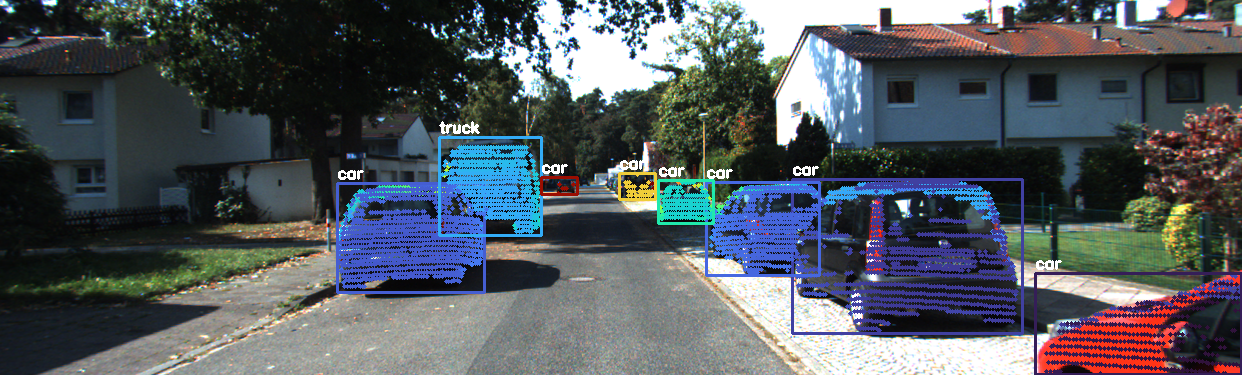

In [21]:
LiDAR2Camera.show_filtered_lidar_on_image = show_filtered_lidar_on_image
test_image = cv2.imread(image_files[index])
img_4 = lidar2cam.show_filtered_lidar_on_image(masks, boxes, classes, class_names, test_image)
cv2_imshow(img_4)

In [22]:
def pipeline(self, image, points):
  lidar_on_image = self.show_lidar_on_image(points[:,:3], test_image)

  cfg, outputs = self.get_segmentation(image)

  # setup
  classes = outputs["instances"].pred_classes.cpu().numpy()
  class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes")
  boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  masks = outputs["instances"].pred_masks.cpu()

  filtered_lidar_on_image = self.show_filtered_lidar_on_image(masks, boxes, classes, class_names, image)

  return filtered_lidar_on_image

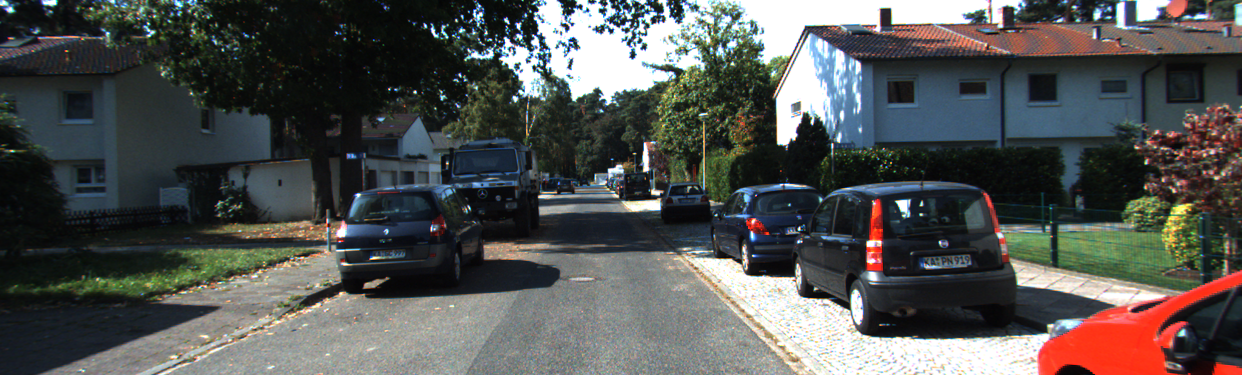

[08/04 18:01:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


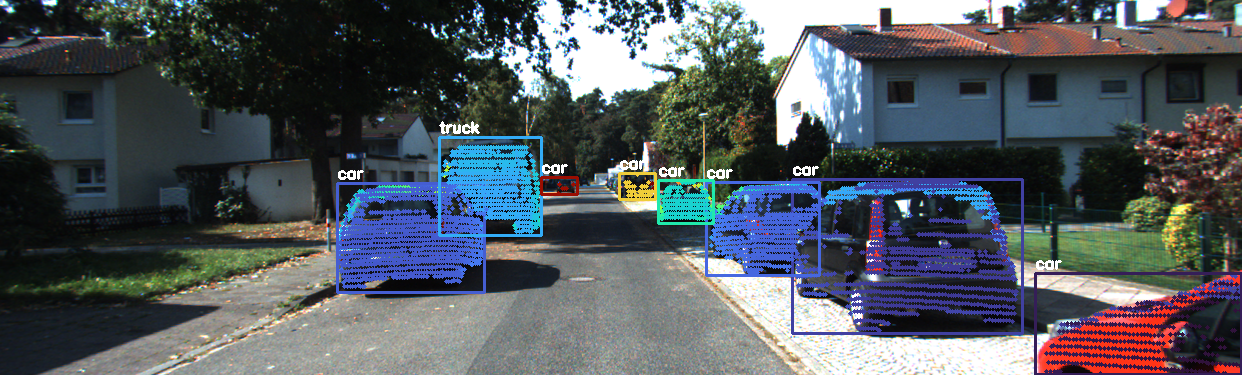

In [23]:
index = 0
image, points = display_image(index, image_files, point_files)

LiDAR2Camera.pipeline = pipeline
lidar2cam = LiDAR2Camera(calib_files[index])
img_5 = lidar2cam.pipeline(image, points)
cv2_imshow(img_5)

In [28]:
video_images = sorted(glob.glob("data/test_videos/video_2/images/*.png"))
video_points = sorted(glob.glob("data/test_videos/video_2/points/*.pcd"))

In [30]:
lidar2cam_video = LiDAR2Camera(calib_files[0])
result_video = []
for idx, img in enumerate(video_images):
    print(f"Processing: Image {idx+1}, remaining {(len(video_images) - (idx + 1))}")
    image = cv2.imread(img)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.pipeline(image, point_cloud))

out = cv2.VideoWriter('output/out1xyza.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 20, (image.shape[1], image.shape[0]))

if not out.isOpened():
    print("Error: Could not open VideoWriter.")

for result in result_video:
    out.write(result)
out.release()

Processing: Image 1, remaining 99
[08/04 18:20:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Processing: Image 2, remaining 98
[08/04 18:20:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Processing: Image 3, remaining 97
[08/04 18:20:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Processing: Image 4, remaining 96
[08/04 18:20:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Processing: Image 5, remaining 95
[08/04 18:20:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] L